# Deep Deterministic Policy Gradient (DDPG) Agent for Continuous Control in Lunar Lander Environment
## By May Cooper
This project implements a Deep Deterministic Policy Gradient (DDPG) agent to solve the Lunar Lander Continuous-v2 environment from OpenAI Gym. The DDPG algorithm is an actor-critic method designed for environments with continuous action spaces, making it suitable for complex control tasks like lunar landing.

## Components:

### Experience Replay Buffer:
- **TransitionMemory**: A buffer to store and sample transitions (state, action, reward, next state, done) to break the temporal correlations during training and stabilize the learning process.

### DDPG Architecture:
- **PolicyNetwork (Actor)**: Responsible for selecting actions based on the current state.
- **ValueNetwork (Critic)**: Evaluates the actions taken by the actor by estimating the Q-values.

### DDPG Agent Class:
- **DDPGAgent**: Manages the actor and critic networks, handles action selection with added exploration noise, and updates the networks based on sampled experiences from the replay buffer.

### Reinforcement Learning Environment Setup and Training Loop:
- Sets up the Lunar Lander environment, initializes hyperparameters, and runs the training loop. The agent interacts with the environment, stores experiences in the replay buffer, and updates the networks.

### Plotting and Statistics Calculation:
- Functions and scripts to calculate running averages of rewards and episode lengths, and plot these statistics to visualize the agent's performance over time.


In [35]:
pip install swig

In [36]:
pip install gym[box2d]

In [92]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [93]:
# Determine the computation device based on availability
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## LunarLander Environment Overview

LunarLander is a challenging environment provided by OpenAI Gym. In this environment, the objective is for the agent to safely navigate a lunar lander to a designated landing pad. The agent's performance is evaluated through a reward system:

- **Navigational Reward**: The agent receives positive rewards for successfully navigating towards the landing pad and turning off the engine at the appropriate times.
- **Safe Landing Reward**: A substantial reward is granted for achieving a safe landing on the pad, indicating the agent has effectively learned to control the lander.
- **Crash Penalty**: A significant negative reward is given for an unsafe landing or crash, encouraging the agent to avoid such outcomes.
- **Engine Usage Penalty**: To promote efficient use of the lander's engines, the agent incurs a small negative reward each time the engines are used.

### Discrete and Continuous Versions

The LunarLander environment is available in two versions:

- **Discrete Version**: In this version, the agent selects from a set of discrete actions to control the lander's engines.
- **Continuous Version**: This version offers a more complex challenge where the agent must control two engines with continuous action values ranging from -1 to 1. This requires the agent to determine the precise thrust needed for each engine to achieve a safe landing.

The continuous version is particularly suited for testing advanced reinforcement learning algorithms like Deep Deterministic Policy Gradient (DDPG), which can handle the nuances of continuous action spaces effectively.


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


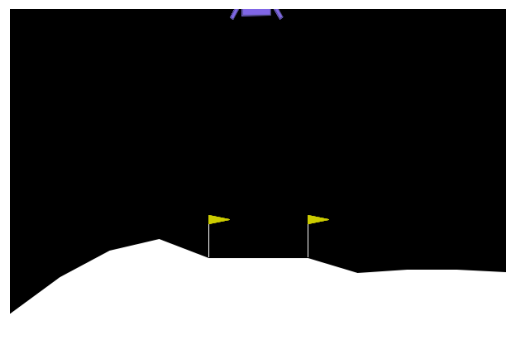

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [94]:
import gym
import matplotlib.pyplot as plt

# Initialize the environment for the Lunar Lander Continuous v2
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# Display the initial state of the environment in non-graphical mode
initial_screen = env.render(mode='rgb_array')
plt.imshow(initial_screen)
plt.axis('off')  # Hide axes for a cleaner view
plt.show()  # Display the initial state using matplotlib

# Simulate the environment for 200 steps
for step in range(200):
    action = env.action_space.sample()  # Randomly sample an action
    observation, reward, termination, info = env.step(action)  # Apply the action

    # Check if the environment needs to be reset after an episode ends
    if termination:
        env.reset()

# Clean up the environment's resources
env.close()


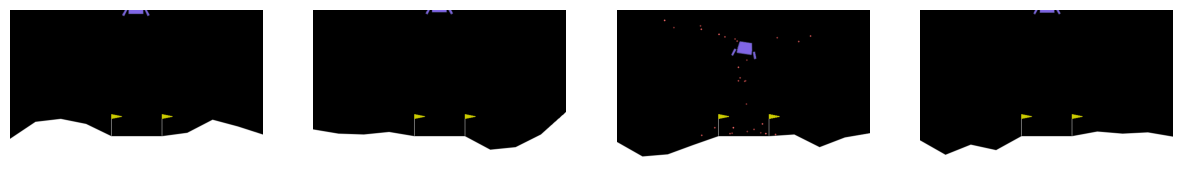

In [95]:
import gym
import matplotlib.pyplot as plt

# Initialize the environment for the Lunar Lander Continuous v2
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# Store images for initial, middle, and final states
images = []

# Get the initial state image without trying to render a GUI window
initial_screen = env.render(mode='rgb_array')
images.append(initial_screen)

# Number of steps to simulate
total_steps = 200
mid_point = total_steps // 2

# Simulate the environment for 200 steps
for step in range(total_steps):
    action = env.action_space.sample()  # Randomly sample an action
    observation, reward, termination, info = env.step(action)  # Apply the action

    if step == mid_point:
        # Capture the middle state of the environment
        mid_screen = env.render(mode='rgb_array')
        images.append(mid_screen)

    # Check if the environment needs to be reset after an episode ends
    if termination:
        env.reset()
        # Optionally capture the state right before reset
        final_screen = env.render(mode='rgb_array')
        images.append(final_screen)
        env.reset()

# Clean up the environment's resources
env.close()

# Display the images
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axes for clarity
plt.show()


### Experience Replay Buffer

In [96]:
class ExperienceMemory():
    def __init__(self, capacity=1e6):
        self.buffer = []
        self.capacity = int(capacity)
        self.index = 0

    def store(self, transition):
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[int(self.index)] = transition
            self.index = (self.index + 1) % self.capacity

    def batch_sample(self, size):
        indices = np.random.randint(0, len(self.buffer), size=size)
        states, next_states, actions, rewards, terminals = [], [], [], [], []

        for idx in indices:
            s, ns, a, r, t = self.buffer[idx]
            states.append(np.array(s, copy=False))
            next_states.append(np.array(ns, copy=False))
            actions.append(np.array(a, copy=False))
            rewards.append(np.array(r, copy=False))
            terminals.append(np.array(t, copy=False))

        return np.array(states), np.array(next_states), np.array(actions), np.array(rewards).reshape(-1,1), np.array(terminals).reshape(-1,1)


### DDPG Architecture

The actor network in Deep Deterministic Policy Gradient (DDPG) utilizes deterministic policy gradients for training. DDPG is an off-policy algorithm that incorporates methods from Deep Q Networks (DQN), including updating target networks and using an experience replay buffer. Unlike DQN, DDPG is designed to handle continuous action spaces. In this example, we employ DDPG to train a network on the continuous Lunar Lander problem.

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action

    def forward(self, state):
        state = torch.clamp(state, -1.1, 1.1)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * self.max_action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        state_action = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


### DDPGAgent Class

The `DDPGAgent` class implements the Deep Deterministic Policy Gradient (DDPG) algorithm, which is a model-free, off-policy reinforcement learning method tailored specifically for environments that feature continuous action spaces. This class encapsulates all necessary functionalities required to train an agent using both policy-based and value-based strategies within such contexts.

## Key Features

- **Actor-Critic Architecture**: The DDPG algorithm adopts an actor-critic structure. The actor is responsible for updating the policy distribution in the direction suggested by the critic, which evaluates the quality of actions taken by the actor. This methodology helps in refining the policy towards optimal actions.

- **Target Networks**: Stability during training is crucial, especially in complex environments. DDPG enhances stability by maintaining separate, slow-moving target networks for both the actor and the critic. These networks provide a fixed baseline for updating the main networks and are updated using a soft update mechanism.

- **Experience Replay**: To mitigate issues related to the correlation of consecutive observations and to improve sample efficiency, the `DDPGAgent` employs an experience replay mechanism. This strategy stores past transitions, which are later used for training the agent asynchronously from the environment's current state.

- **Batch Normalization**: Batch normalization is used within the network to handle varying scales of inputs effectively. It normalizes the inputs to each layer so that the network remains effective across a wide range of input values without needing significant changes to the hyperparameters.

The `DDPGAgent` class provides a structured approach to applying the DDPG algorithm in various simulation environments, facilitating both research and practical applications in fields such as robotics and automated systems.


In [98]:
class DDPG():
    def __init__(self, state_dim, action_dim, hidden_dim, actor_lr, critic_lr, gamma, min_action, max_action, noise_stddev):
        self.action_dim = action_dim
        self.actor = Actor(state_dim, action_dim, hidden_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, hidden_dim, max_action).to(device)
        self.critic = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.min_action = min_action
        self.max_action = max_action
        self.noise_stddev = noise_stddev

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        action = self.actor(state).detach().cpu().numpy()
        action += np.random.normal(0, self.noise_stddev, size=self.action_dim)
        return np.clip(action, self.min_action, self.max_action)

    def train(self, memory, batch_size):
        state_batch, next_state_batch, action_batch, reward_batch, done_batch = memory.batch_sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(device)
        action_batch = torch.FloatTensor(action_batch).to(device)
        reward_batch = torch.FloatTensor(reward_batch).to(device)
        done_batch = torch.FloatTensor(done_batch).to(device)

        with torch.no_grad():
            next_action = self.actor_target(next_state_batch)
            target_Q = self.critic_target(next_state_batch, next_action)
            target_Q = reward_batch + self.gamma * (1 - done_batch) * target_Q

        current_Q = self.critic(state_batch, action_batch)
        critic_loss = F.mse_loss(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(state_batch, self.actor(state_batch)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return actor_loss.item(), critic_loss.item()  # Return the loss values here

    def update_targets(self, tau):
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [99]:
import gym
import numpy as np
import torch

env = gym.make('LunarLanderContinuous-v2')
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

memory_capacity = 50000
memory = ExperienceMemory(capacity=memory_capacity)

train_start = 10001
update_frequency = 1
soft_tau = 0.001

total_episodes = 5000
gamma = 0.99
batch_size = 32
noise_level = 0.1
hidden_units = 64
learning_rate_actor = 0.0005
learning_rate_critic = 0.0005
scale_reward = 0.01

agent = DDPG(state_dim, action_dim, hidden_units, learning_rate_actor, learning_rate_critic, gamma, min_action, max_action, noise_level)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Overview of the Reinforcement Learning (RL) Training Process

The training loop in reinforcement learning is a structured sequence where we iteratively process episodes and their respective timesteps. This loop continues until a predefined stopping criterion is met, which might be reaching the maximum number of episodes, exceeding a limit on timesteps, or achieving a specific performance threshold by the agent.

Within each episode, the process unfolds timestep by timestep. At every step, the agent performs the following actions:

- **Action Selection**: The agent chooses an action based on the current state, guided by its policy.
- **Environment Interaction**: The chosen action is executed in the environment using the `env.step()` function, which returns the new state, reward, and a flag indicating whether the episode has ended.
- **Data Storage**: The agent stores the state transition (current state, action, reward, next state, and done flag) in the replay buffer. This buffer holds a collection of such transitions, allowing the agent to learn from a wider range of experiences.
- **Network Training**: Concurrently with data accumulation, the agent trains its neural network, which involves adjusting the network parameters to better predict the value of actions given the current state.
- **Target Network Updates**: Periodically, the agent updates its target network. This network helps stabilize the learning process by providing a consistent target for the training network's output. The updates are typically less frequent and use a weighted average of the training network's parameters to maintain stability.

Whenever an episode concludes, indicated by the `done` flag from the environment, the environment is reset to start a new episode, ensuring continuous and diverse learning opportunities.


In [100]:
# import numpy as np

# reward_statistics = []
# update_interval = 10
# total_rewards = 0
# total_timesteps = 0
# episode_lengths = []
# stats_actor_loss, stats_critic_loss = [], []

# for episode in range(total_episodes):
#     state = env.reset()
#     episode_reward = 0
#     episode_length = 0

#     while True:
#         total_timesteps += 1
#         action = agent.select_action(state)
#         next_state, reward, done, _ = env.step(action)
#         episode_reward += reward
#         episode_length += 1

#         scaled_reward = reward * scale_reward
#         memory.store((state, next_state, action, scaled_reward, 1 - float(done)))

#         if total_timesteps >= train_start:
#             actor_loss, critic_loss = agent.train(memory, batch_size)
#             stats_actor_loss.append(actor_loss)
#             stats_critic_loss.append(critic_loss)
#             agent.update_targets(soft_tau)

#         if done:
#             reward_statistics.append((episode, episode_reward, episode_length))
#             if episode % update_interval == 0 and episode > 0:
#                 avg_reward = np.mean([r for _, r, _ in reward_statistics[-update_interval:]])
#                 avg_length = np.mean([l for _, _, l in reward_statistics[-update_interval:]])
#                 avg_actor_loss = np.mean(stats_actor_loss) if stats_actor_loss else 0
#                 avg_critic_loss = np.mean(stats_critic_loss) if stats_critic_loss else 0
#                 print(f'Episode: {episode} Timestep: {total_timesteps} Total reward: {avg_reward:.1f} Episode length: {avg_length:.1f} Actor Loss: {avg_actor_loss:.4f} Critic Loss: {avg_critic_loss:.4f}')
#                 stats_actor_loss, stats_critic_loss = [], []  # Reset for next interval
#             break

#         state = next_state


In [112]:
import numpy as np

# Initialization of variables for reinforcement learning
reward_statistics = []
update_interval = 10
total_rewards = 0
total_timesteps = 0
episode_lengths = []
stats_actor_loss = []  # Initialize as an empty list
stats_critic_loss = []  # Initialize as an empty list
paths = []  # List to store paths of each episode

# Total number of episodes to run
total_episodes = 100  # Example value, set this as needed

# Begin simulation of the episodes
for episode in range(total_episodes):  # Outer loop runs total_episodes times
    state = env.reset()  # Reset the environment at the beginning of each episode
    episode_reward = 0
    episode_length = 0
    episode_path = [state[:2]]  # Assuming you're tracking 2D state, adjust if your state space is different

    while True:  # Inner loop runs until done is True
        total_timesteps += 1
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        episode_length += 1
        episode_path.append(next_state[:2])  # Store the necessary parts of the state

        scaled_reward = reward * scale_reward
        memory.store((state, next_state, action, scaled_reward, 1 - float(done)))

        if total_timesteps >= train_start:
            actor_loss, critic_loss = agent.train(memory, batch_size)
            stats_actor_loss.append(actor_loss)
            stats_critic_loss.append(critic_loss)
            agent.update_targets(soft_tau)

        if done:  # Check if the episode is done
            reward_statistics.append((episode, episode_reward, episode_length))
            paths.append(episode_path)  # Append the path of this episode to paths
            if episode % update_interval == 0 and episode > 0:
                avg_reward = np.mean([r for _, r, _ in reward_statistics[-update_interval:]])
                avg_length = np.mean([l for _, _, l in reward_statistics[-update_interval:]])
                avg_actor_loss = np.mean(stats_actor_loss) if stats_actor_loss else 0
                avg_critic_loss = np.mean(stats_critic_loss) if stats_critic_loss else 0
                print(f'Episode: {episode} Timestep: {total_timesteps} Total reward: {avg_reward:.1f} Episode length: {avg_length:.1f} Actor Loss: {avg_actor_loss:.4f} Critic Loss: {avg_critic_loss:.4f}')
                stats_actor_loss = []  # Reset for next interval
                stats_critic_loss = []  # Reset for next interval
            break  # Exit the inner loop when the episode is done

        state = next_state  # Update the state


Episode: 10 Timestep: 1549 Total reward: -229.5 Episode length: 140.7 Actor Loss: 0.0333 Critic Loss: 4.5170
Episode: 20 Timestep: 2307 Total reward: -400.7 Episode length: 75.8 Actor Loss: -0.0115 Critic Loss: 6.3719
Episode: 30 Timestep: 3345 Total reward: -668.0 Episode length: 103.8 Actor Loss: 0.1220 Critic Loss: 12.0458
Episode: 40 Timestep: 9013 Total reward: -328.7 Episode length: 566.8 Actor Loss: 0.1090 Critic Loss: 12.0066
Episode: 50 Timestep: 10761 Total reward: -246.3 Episode length: 174.8 Actor Loss: 0.0086 Critic Loss: 14.9767
Episode: 60 Timestep: 12159 Total reward: -266.3 Episode length: 139.8 Actor Loss: -0.0199 Critic Loss: 17.4002
Episode: 70 Timestep: 13407 Total reward: -301.9 Episode length: 124.8 Actor Loss: 0.0095 Critic Loss: 19.0552
Episode: 80 Timestep: 14586 Total reward: -234.1 Episode length: 117.9 Actor Loss: 0.0810 Critic Loss: 22.5548
Episode: 90 Timestep: 15793 Total reward: -261.0 Episode length: 120.7 Actor Loss: 0.0162 Critic Loss: 24.1174


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecat

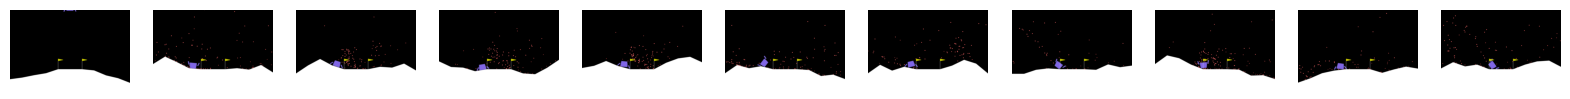

In [113]:
import gym
import matplotlib.pyplot as plt
import numpy as np

# Initialize the environment for the Lunar Lander Continuous v2
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# Store images for initial, regular intervals, and final states
images = []

# Display the initial state of the environment
initial_screen = env.render(mode='rgb_array')
images.append(initial_screen)

# Number of episodes and steps to simulate
total_episodes = 10  # Set as needed
update_interval = 10
scale_reward = 1.0  # Adjust as needed
train_start = 1000  # Adjust as needed
soft_tau = 0.005  # Adjust as needed
batch_size = 64  # Adjust as needed
total_timesteps = 0

# Initialize lists for statistics
reward_statistics = []
episode_lengths = []
stats_actor_loss, stats_critic_loss = [], []

# Simulate episodes
for episode in range(total_episodes):
    state = env.reset()
    episode_reward = 0
    episode_length = 0

    while True:
        total_timesteps += 1
        action = agent.select_action(state)  # Assuming 'agent' is defined elsewhere
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        episode_length += 1

        scaled_reward = reward * scale_reward
        memory.store((state, next_state, action, scaled_reward, 1 - float(done)))

        # Training and updating
        if total_timesteps >= train_start:
            actor_loss, critic_loss = agent.train(memory, batch_size)
            stats_actor_loss.append(actor_loss)
            stats_critic_loss.append(critic_loss)
            agent.update_targets(soft_tau)

        if done:
            reward_statistics.append((episode, episode_reward, episode_length))
            episode_lengths.append(episode_length)
            break

        state = next_state

    # Visualize the environment at the end of each episode
    final_screen = env.render(mode='rgb_array')
    images.append(final_screen)

    # Print statistics periodically
    if episode % update_interval == 0 and episode > 0:
        avg_reward = np.mean([r for _, r, _ in reward_statistics[-update_interval:]])
        avg_length = np.mean(episode_lengths[-update_interval:])
        avg_actor_loss = np.mean(stats_actor_loss) if stats_actor_loss else 0
        avg_critic_loss = np.mean(stats_critic_loss) if stats_critic_loss else 0
        print(f'Episode: {episode} Timestep: {total_timesteps} Total reward: {avg_reward:.1f} Episode length: {avg_length:.1f} Actor Loss: {avg_actor_loss:.4f} Critic Loss: {avg_critic_loss:.4f}')
        stats_actor_loss, stats_critic_loss = [], []  # Reset for next interval

# Clean up the environment's resources
env.close()

# Display the collected images
fig, axs = plt.subplots(1, len(images), figsize=(20, 5))  # Adjust subplot size as needed
for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axes for clarity
plt.show()


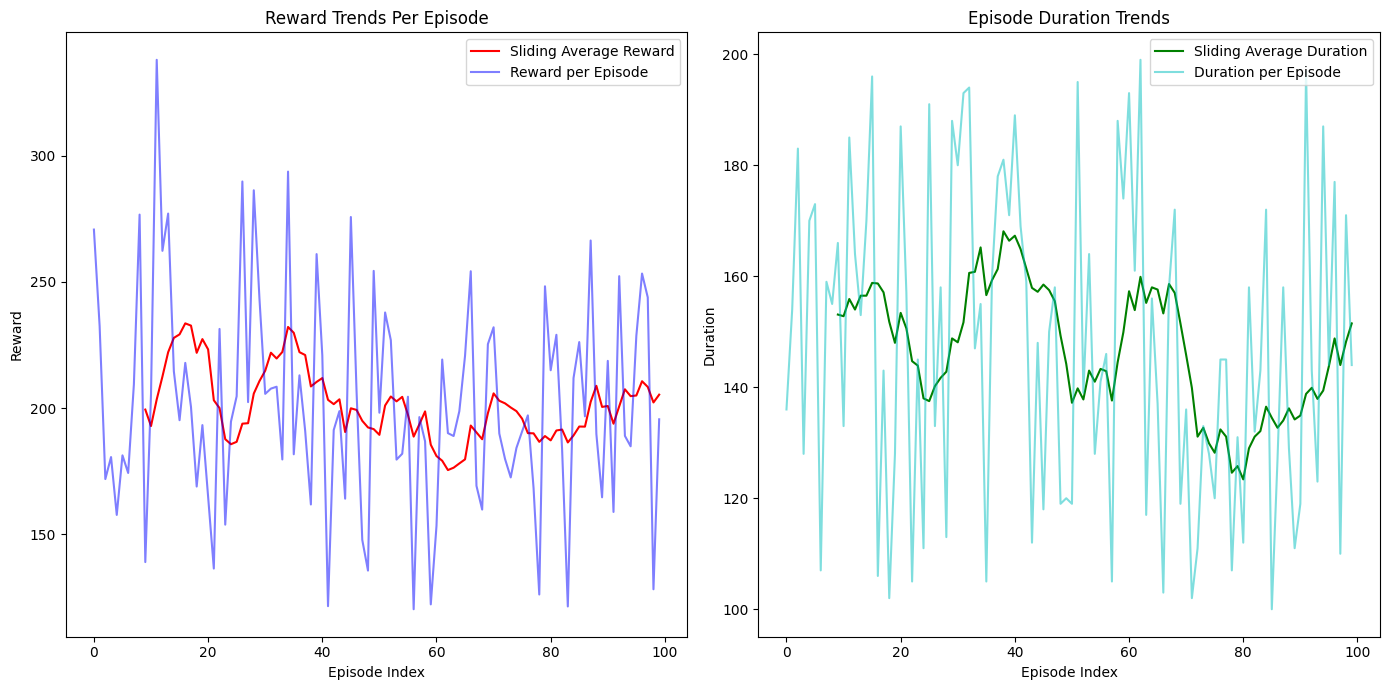

In [114]:
def compute_sliding_average(data, window_size):
    """Calculate the sliding average of a data series over a specified window size."""
    cumulative_sum = np.cumsum(np.insert(data, 0, 0))
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

# Setup for simulation
total_episodes = 100  # Example, set this as required
reward_statistics = []
update_interval = 10

# Simulate data collection
for episode in range(total_episodes):
    episode_reward = np.random.normal(200, 50)  # Example simulated reward
    episode_length = np.random.randint(100, 200)  # Example simulated duration
    reward_statistics.append((episode, episode_reward, episode_length))

# Extract episode indices, rewards, and durations from the statistics list
episode_indices, rewards, durations = np.array(reward_statistics).T

# Compute the sliding averages for rewards and durations
average_rewards = compute_sliding_average(rewards, 10)  # Sliding average of rewards over 10 episodes
average_durations = compute_sliding_average(durations, 10)  # Sliding average of episode durations over 10 episodes

# Plotting the episode rewards
plt.figure(figsize=(14, 7))  # Adjusted for better visualization

# Plot for average rewards
plt.subplot(1, 2, 1)
plt.plot(episode_indices[-len(average_rewards):], average_rewards, 'r-', label='Sliding Average Reward')
plt.plot(episode_indices, rewards, 'b-', alpha=0.5, label='Reward per Episode')
plt.xlabel('Episode Index')
plt.ylabel('Reward')
plt.title('Reward Trends Per Episode')
plt.legend()

# Plot for average durations
plt.subplot(1, 2, 2)
plt.plot(episode_indices[-len(average_durations):], average_durations, 'g-', label='Sliding Average Duration')
plt.plot(episode_indices, durations, 'c-', alpha=0.5, label='Duration per Episode')
plt.xlabel('Episode Index')
plt.ylabel('Duration')
plt.title('Episode Duration Trends')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

# Distribution of Episode Rewards

Below, we visualize the distribution of episode rewards accumulated by the agent during the training process. By plotting a histogram with a Kernel Density Estimate (KDE) overlay, we can observe several aspects of the agent's performance:

<ul>
  <li><strong>Frequency</strong>: How often the agent achieves certain reward levels, indicating its consistency.</li>
  <li><strong>Spread</strong>: The range of rewards, showing the variability in the agent's performance.</li>
  <li><strong>Overall Performance</strong>: Insights into whether the agent is improving over time or if there are significant fluctuations in its rewards.</li>
</ul>


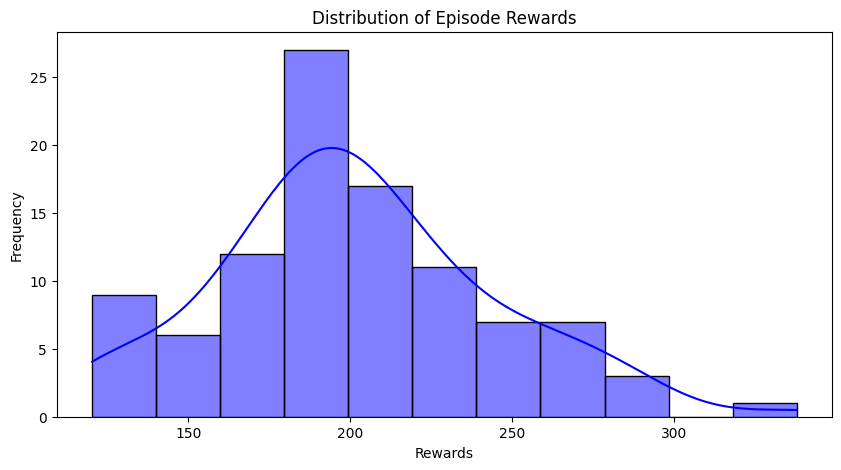

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

episode_rewards = [r[1] for r in reward_statistics]

plt.figure(figsize=(10, 5))
sns.histplot(episode_rewards, kde=True, color='blue')
plt.title('Distribution of Episode Rewards')
plt.xlabel('Rewards')
plt.ylabel('Frequency')
plt.show()


#Episode Length Over Time
Here we visualize the length of episodes over time during the training process. By plotting the episode lengths, we can observe several aspects of the agent's performance:

<ul>
  <li><strong>Episode Progression</strong>: How the length of episodes changes over time, indicating whether the agent is learning to complete episodes more efficiently.</li>
  <li><strong>Consistency</strong>: The variability in episode lengths, showing the consistency of the agent's performance.</li>
  <li><strong>Learning Stability</strong>: Insights into whether the agent's performance stabilizes as training progresses or if there are significant fluctuations in episode lengths.</li>
</ul>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


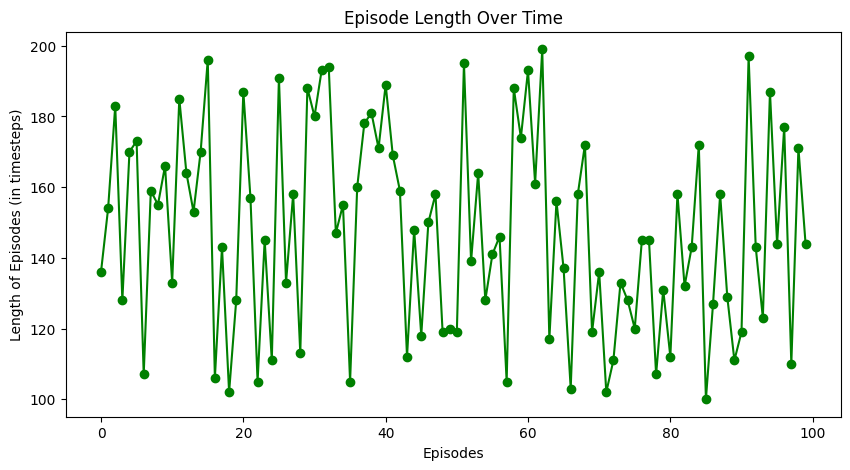

In [116]:
import matplotlib.pyplot as plt

episode_lengths = [r[2] for r in reward_statistics]  # Extracting lengths of episodes
episodes = [r[0] for r in reward_statistics]  # Extracting episode numbers

plt.figure(figsize=(10, 5))
plt.plot(episodes, episode_lengths, marker='o', linestyle='-', color='green')
plt.title('Episode Length Over Time')
plt.xlabel('Episodes')
plt.ylabel('Length of Episodes (in timesteps)')
plt.show()


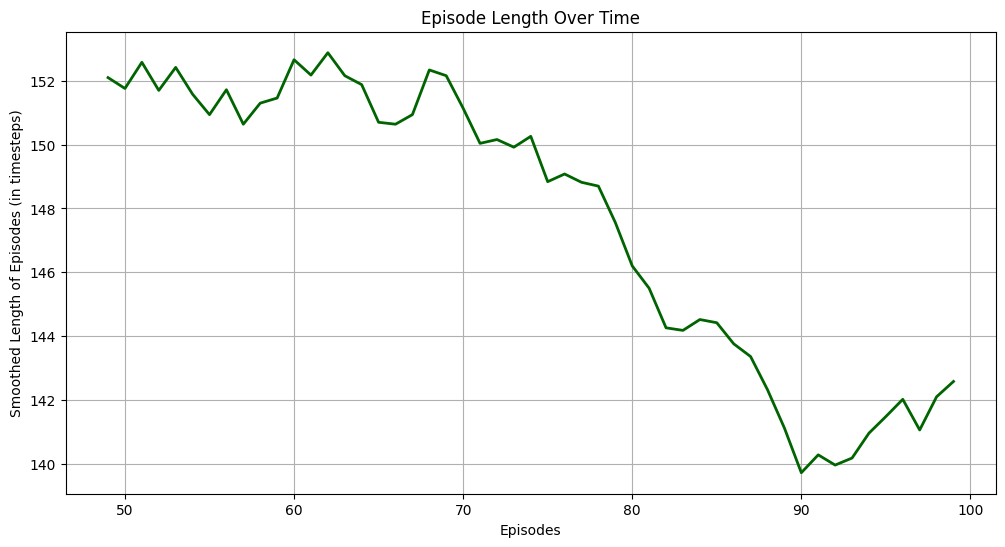

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming episode_lengths and episodes are already defined and extracted as shown in previous code
episode_lengths = [r[2] for r in reward_statistics]  # Extracting lengths of episodes
episodes = [r[0] for r in reward_statistics]  # Extracting episode numbers

# Smooth the data using a simple moving average
def smooth_data(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_episode_lengths = smooth_data(episode_lengths, 50)  # Example: window size of 50

plt.figure(figsize=(12, 6))
plt.plot(episodes[len(episodes) - len(smoothed_episode_lengths):], smoothed_episode_lengths, linestyle='-', color='darkgreen', linewidth=2)
plt.title('Episode Length Over Time')
plt.xlabel('Episodes')
plt.ylabel('Smoothed Length of Episodes (in timesteps)')
plt.grid(True)
plt.show()


# Episode Length Over Time
Here is a scatter plot that visualizes the relationship between episode lengths and episode rewards. Each point represents an episode, with the x-coordinate indicating the length of the episode (in timesteps) and the y-coordinate representing the reward received. This plot helps to analyze the correlation between episode duration and rewards, with the grid enhancing readability for identifying patterns and trends.

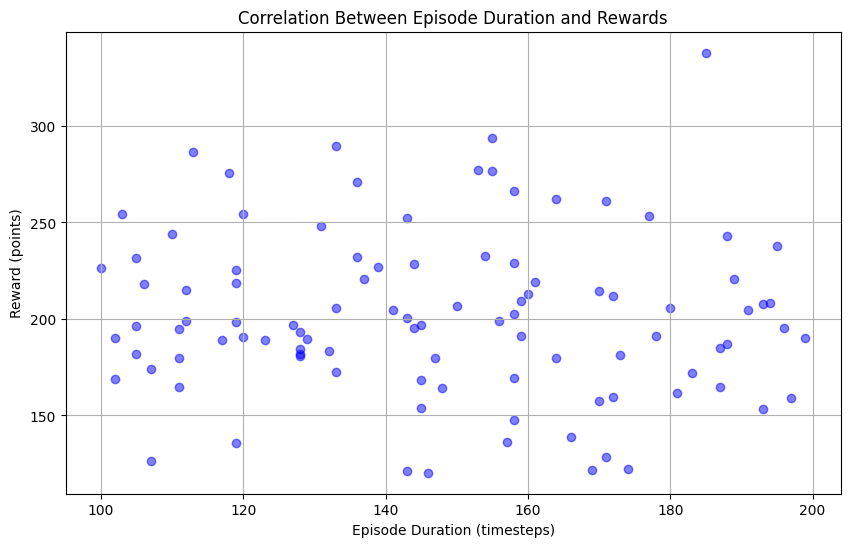

In [118]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))  # Set the figure size for clear visibility
plt.scatter(durations, rewards, alpha=0.5, c='blue')  # Use magenta color for the points
plt.title('Correlation Between Episode Duration and Rewards')  # Set the title of the plot
plt.xlabel('Episode Duration (timesteps)')  # Label the x-axis as 'Episode Duration' and add units
plt.ylabel('Reward (points)')  # Label the y-axis as 'Reward' and add units
plt.grid(True)  # Enable grid for easier analysis
plt.show()  # Display the plot


#Reward Distribution Across Episode Batches
This visualizes the distribution of episode rewards across batches of episodes. Each batch consists of 50 episodes, and the rewards within each batch are grouped together to show their distribution.

The batch_labels list creates labels for each set of 50 episodes, helping to organize the data into batches. The box plot provides insights into the range, median, and variability of rewards within each batch, making it easier to compare performance across different segments of the training process.

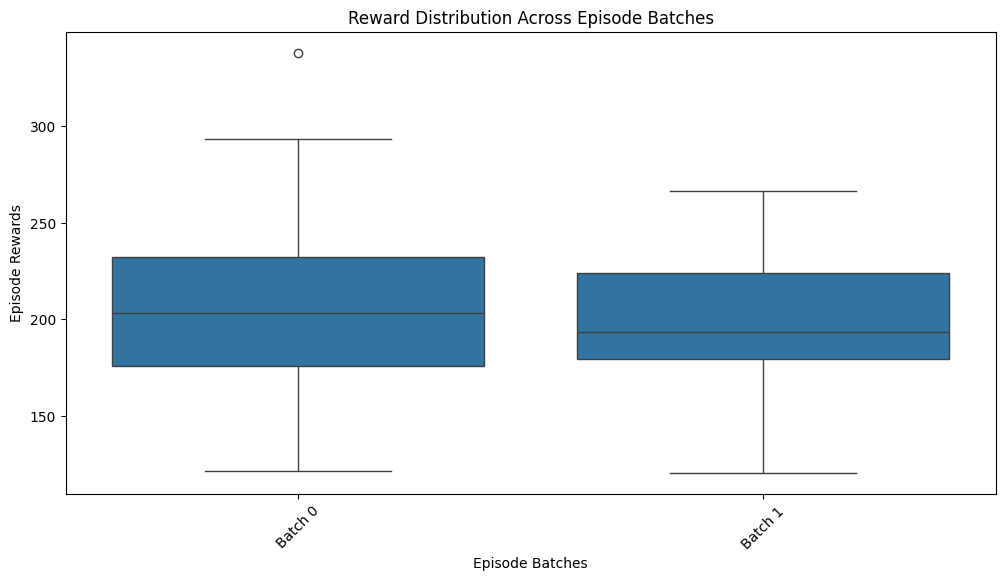

In [119]:
import seaborn as sns

# Create a batch label for each set of 50 episodes
batch_labels = [f'Batch {i//50}' for i in episodes]

plt.figure(figsize=(12, 6))
sns.boxplot(x=batch_labels, y=episode_rewards)
plt.title('Reward Distribution Across Episode Batches')
plt.xlabel('Episode Batches')
plt.ylabel('Episode Rewards')
plt.xticks(rotation=45)
plt.show()


# Seasonal Decomposition of Episode Rewards
Here, we perform a seasonal decomposition of the episode rewards time series to break it down into three main components: trend, seasonality, and residuals. This analysis helps to understand the underlying patterns in the data and provides insights into the structure and behavior of the rewards over time.

- **Original**: The initial time series of episode rewards, representing raw data with all underlying patterns, trends, seasonal effects, and noise.

- **Trend**: Captures the long-term progression of the series, showing the general direction of rewards over time. This can indicate improvements, deteriorations, or consistent performance in the agent's actions.

- **Seasonality**: Represents repeating short-term cycles in the series, indicating regular fluctuations at consistent intervals. This could reflect periodic changes in performance due to various factors.

- **Residuals**: The remaining part of the series after removing the trend and seasonality, capturing random noise or irregularities. This helps in understanding the variability and randomness in the data.

Seasonal decomposition is a technique used to break down the episode rewards time series into three main components: trend, seasonality, and residuals.

- **Trend**: Shows the long-term direction in the episode rewards.
- **Seasonality**: Captures regular patterns or cycles in the rewards.
- **Residuals**: Represents random noise or irregularities after removing the trend and seasonal components

This decomposition helps to understand the underlying patterns in the data, providing insights into the agent's performance over time.

The `seasonal_decompose` function from the `statsmodels` library is used for this analysis. It separates the time series into these components, allowing for individual visualization and analysis. The resulting components are plotted alongside the original series for comprehensive insights into the underlying patterns in the episode rewards.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


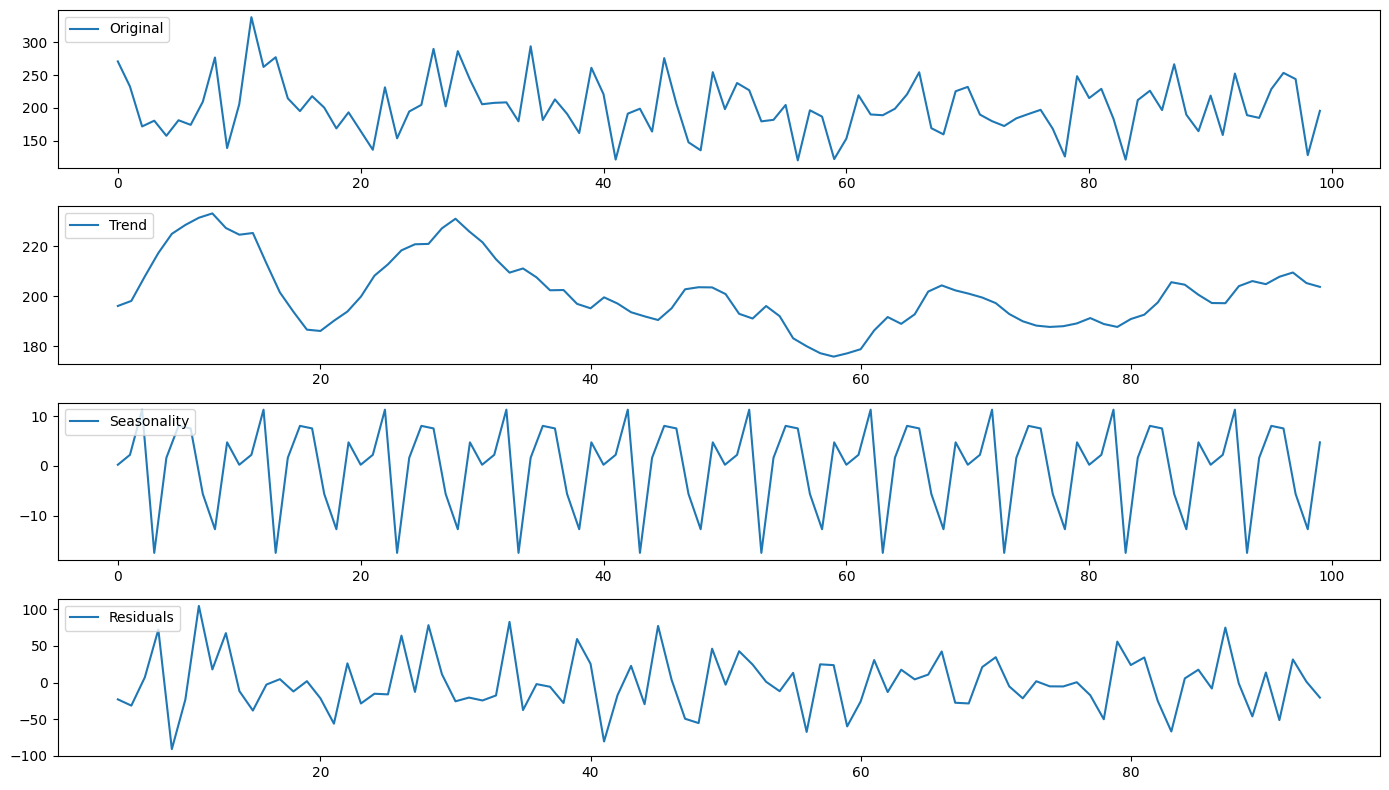

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming reward_statistics is populated from the provided code snippet
# Extract episode rewards for decomposition
episode_rewards = [r[1] for r in reward_statistics]
episodes = [r[0] for r in reward_statistics]

# Create a pandas Series with a regular index (if episodes are sequential and regular)
episode_rewards_series = pd.Series(episode_rewards, index=pd.RangeIndex(start=episodes[0], stop=episodes[-1]+1, step=1))

# Check if the series has a sufficient length and no missing values for decomposition
if len(episode_rewards_series) > 2 and episode_rewards_series.isnull().sum() == 0:
    # Decompose the series assuming additive model (or change to 'multiplicative' if the context suggests)
    decomposition = seasonal_decompose(episode_rewards_series, model='additive', period=update_interval)  # Ensure 'period' matches your data's seasonality

    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    # Plotting the original series and its decomposition components
    plt.figure(figsize=(14, 8))
    plt.subplot(411)
    plt.plot(episode_rewards_series, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data length or missing values detected.")


# Agent Paths in Environment Over Time
Here is an animation that visualizes the paths taken by the agent in the environment over time. The plot updates dynamically to show the agent's position at each timestep.

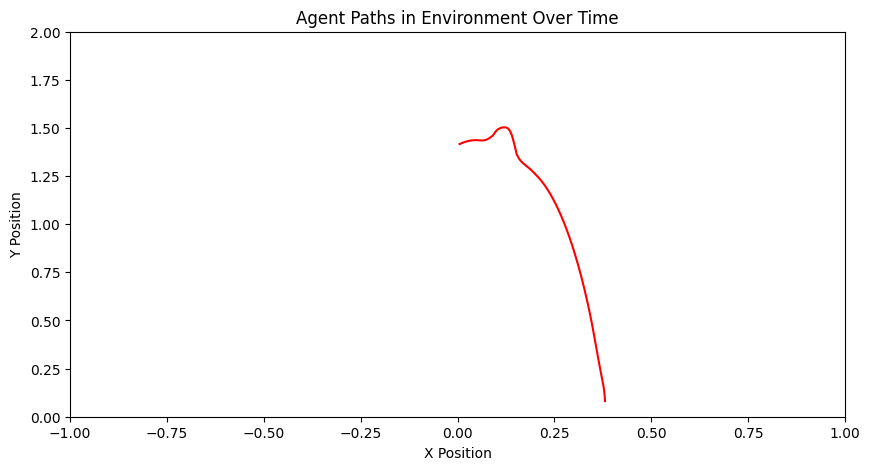

In [121]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(10, 5))

def update(num, paths, line):
    line.set_data([state[0] for state in paths[num]], [state[1] for state in paths[num]])
    return line,

line, = ax.plot([], [], 'r-')
plt.xlim(-1, 1)  # Set these limits according to your state space
plt.ylim(0, 2)
plt.title('Agent Paths in Environment Over Time')
plt.xlabel('X Position')
plt.ylabel('Y Position')

ani = animation.FuncAnimation(fig, update, len(paths), fargs=[paths, line],
                              interval=1000, blit=True)
plt.show()


# Average Agent Path in Environment
Here, we calculate and plots the average path taken by the agent in the environment. It helps to visualize the general trajectory of the agent over multiple episodes.

1. **Truncate Paths**:
   - Finds the minimum length among all paths to ensure consistency.
   - Truncates all paths to this minimum length to avoid errors during computation.

2. **Compute Average Path**:
   - Calculates the average x and y positions across all truncated paths.

3. **Plot Average Path**:
   - Plots the average path to visualize the general trajectory of the agent in the environment.


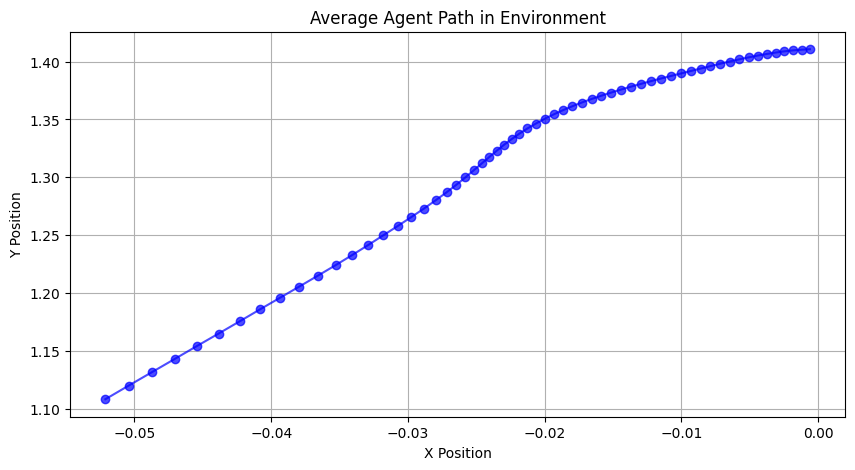

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Find the minimum length of any path in paths to avoid errors when computing the mean
min_length = min(len(path) for path in paths)

# Truncate all paths to the minimum length and compute the average path
if min_length > 0:
    truncated_paths_x = [path[:min_length] for path in paths]
    truncated_paths_y = [path[:min_length] for path in paths]

    average_path_x = np.mean([[state[0] for state in path] for path in truncated_paths_x], axis=0)
    average_path_y = np.mean([[state[1] for state in path] for path in truncated_paths_y], axis=0)

    # Plot the average path
    plt.figure(figsize=(10, 5))
    plt.plot(average_path_x, average_path_y, 'bo-', alpha=0.7)
    plt.title('Average Agent Path in Environment')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.show()
else:
    print("No paths available to plot.")
